# Fall 2020: DS-GA 1011 NLP with Representation Learning
## Lab 8: 31-Oct-2022, Monday
## Masked Language Modeling

In this lab, we will overview the **masked language modeling** objective, and the popular model architecture **Transformer** used for large-scale masked language modeling.

In [1]:
! pip install jsonlines

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
import os
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
os.chdir("/content/drive/MyDrive/Labs/08")
os.listdir()
import utils

In [4]:
# # Import required packages
import math, time
import numpy as np
from tqdm import tqdm

import torch
import torch.nn as nn
from torch.utils.data.dataloader import DataLoader

import matplotlib.pyplot as plt
from ipywidgets import interactive

c.f.
> `ipywidgets` are interactive HTML widgets for Jupyter notebooks, JupyterLab and the IPython kernel. Notebooks come alive when interactive widgets are used. Users gain control of their data and can visualize changes in the data.

---
### Background

Recently, Devlin et al. published [BERT: Pre-training of Deep Bidirectional Transformers for
Language Understanding](https://arxiv.org/pdf/1810.04805.pdf).


**B**idirectional

**E**ncoder

**R**epresentations from

**T**ransformers


#### Goal: 
1. **pre-train** a model that produces language representations. (*this week's lab*)
2. **fine-tune** the model on a task. (*next week's lab*)

---
### Masked Language Model Objective

Randomly mask some of the tokens from the input, predict original vocabulary id of each masked token.

- Given sequence $x_1,\ldots,x_N$.

- Form **mask** $m_1,\ldots,m_N$ where $m_i\in \{0,1\}$.
    - E.g. $m_i=1$ with probability 0.15
    
- Form **masked sequence** $\tilde{x}_1,\ldots,\tilde{x}_N$.

  $ \tilde{x}_i = \begin{cases}
x_i & m_i = 0 \\ \texttt{[MASK]} & \textrm{otherwise}
\end{cases}$


#### $$\mathcal{L}_{\text{MLM}}=-\sum_{\underbrace{i | m_i=1}_{\text{MASKED POSITIONS}}}\log p_{\theta}(\underbrace{x_i}_{\text{TRUE TOKEN}}|\underbrace{\tilde{x}_1,\ldots,\tilde{x}_N}_{\text{MASKED SEQUENCE}})$$


<!-- Below, we will discuss the exact form of $\tilde{x}_i$ that the BERT authors used. -->


<!-- #### Diagram of BERT Implementation -->
<!-- ![](bert_overview.png) -->

---
### Transformers

So far we have modeled a sequence by factorizing the joint distribution into conditionals, and **parameterizing each conditional with a recurrent network**:


#### $$p_{\theta}(x_1,\ldots,x_T)=\prod_{t=1}^T p_{\theta}(x_t | x_{<t})$$
\begin{align}
h_t &= RNN(x_t, h_{t-1})\\
p_{\theta}(x_t | x_{< t}) &=\text{softmax}\left(Wh_t+b\right),
\end{align}

where $\theta$ are the model parameters (RNN parameters, $W, b$, embedding matrix).


#### Alternative

An alternative proposed in [[Vaswani et al 2017](https://arxiv.org/pdf/1706.03762.pdf)] is to parameterize each conditional with a **particular feed-forward architecture** called the **Transformer**. With this model, it is possible to compute all conditionals with a **single feed-forward pass**:
\begin{align}
(h_1,\ldots,h_T) &= Transformer(x)\\
p_{\theta}(x_t | x_{\neq t}) &= \text{softmax}\left(Wh_t + b\right)
\end{align}

We will discuss briefly the key ideas, the overall Transformer architecture (encoder only), and how they are used in Pytorch.

#### High-Level View

We can view the Transformer encoder as mapping a sequence to a sequence of vectors.


<img src="img/high1.png" alt="Drawing" style="width: 35%;"/>

Let's step through the key ideas of how this mapping is designed, and discuss some of its resulting properties.

#### Key Idea 1: Position Embeddings

Unlike RNNs which can learn positional information via the hidden state over time, the Transformer has no notion of time (**similar to the bag-of-words model**).

Thus we encode inputs with **position** as well as **token** embeddings:

<img src="img/high2.png" alt="Drawing" style="width: 35%;"/>

In [5]:
input_sequence = ['<s>', 'my', 'pet', '[M]', '<s>']

max_len = 10

vocab = {'<s>': 0, 'my': 1, 'pet': 2, 'dog': 3, 'cat': 4, 'lion': 5, '[M]': 6}

dim = 6

token_embed = nn.Embedding(len(vocab), embedding_dim=dim)
position_embed = nn.Embedding(max_len, embedding_dim=dim)

In [6]:
input_vector = torch.tensor([vocab[x] for x in input_sequence]).unsqueeze(1)
pos_vector = torch.arange(len(input_vector)).unsqueeze(1)

print(input_vector, input_vector.size(), '\n', pos_vector, pos_vector.size())

tensor([[0],
        [1],
        [2],
        [6],
        [0]]) torch.Size([5, 1]) 
 tensor([[0],
        [1],
        [2],
        [3],
        [4]]) torch.Size([5, 1])


In [7]:
input_embeddings = token_embed(input_vector) + position_embed(pos_vector)
print(input_embeddings, input_embeddings.size())

tensor([[[ 0.0305, -1.4246,  1.8898, -1.4689,  2.6718,  1.9441]],

        [[-2.5412, -1.4245, -2.0117, -0.0189, -1.3437, -0.2513]],

        [[-0.2313,  2.8521,  0.4405,  0.0918,  0.8294, -3.0859]],

        [[-1.1441,  1.8045, -0.8676, -1.9954, -1.0629, -1.9882]],

        [[ 1.3537, -1.4839,  2.1776, -0.5902,  1.6655,  1.1690]]],
       grad_fn=<AddBackward0>) torch.Size([5, 1, 6])


**Warning!!** The pytorch Transformer classes accept input as `Length x Batch x Dim`

#### Key Idea 2: Modularity
The Transformer (encoder) is composed of a stack of **N identical layers**.

<img src="img/layers.png" alt="Drawing" style="width: 35%;"/>

In [8]:
nn.TransformerEncoder?

#### The `forward` passes the input through the N layers, then normalizes it:

**Warning!!** The forward function accepts input as `Length x Batch x Dim`

In [ ]:
nn.TransformerEncoder.forward??

Signature:
nn.TransformerEncoder.forward(
    self,
    src: torch.Tensor,
    mask: Union[torch.Tensor, NoneType] = None,
    src_key_padding_mask: Union[torch.Tensor, NoneType] = None,
) -> torch.Tensor
Source:   
    def forward(self, src: Tensor, mask: Optional[Tensor] = None, src_key_padding_mask: Optional[Tensor] = None) -> Tensor:
        r"""Pass the input through the encoder layers in turn.

        Args:
            src: the sequence to the encoder (required).
            mask: the mask for the src sequence (optional).
            src_key_padding_mask: the mask for the src keys per batch (optional).

        Shape:
            see the docs in Transformer class.
        """
        output = src

        for mod in self.layers:
            output = mod(output, src_mask=mask, src_key_padding_mask=src_key_padding_mask)

        if self.norm is not None:
            output = self.norm(output)

        return output
File:      /opt/anaconda3/lib/python3.8/site-packages/torch/nn/mod

In [9]:
encoder_layer = nn.TransformerEncoderLayer(d_model=dim, nhead=2, dim_feedforward=64, dropout=0.1)

encoder = nn.TransformerEncoder(encoder_layer, num_layers=4)

In [10]:
print(encoder)

TransformerEncoder(
  (layers): ModuleList(
    (0): TransformerEncoderLayer(
      (self_attn): MultiheadAttention(
        (out_proj): NonDynamicallyQuantizableLinear(in_features=6, out_features=6, bias=True)
      )
      (linear1): Linear(in_features=6, out_features=64, bias=True)
      (dropout): Dropout(p=0.1, inplace=False)
      (linear2): Linear(in_features=64, out_features=6, bias=True)
      (norm1): LayerNorm((6,), eps=1e-05, elementwise_affine=True)
      (norm2): LayerNorm((6,), eps=1e-05, elementwise_affine=True)
      (dropout1): Dropout(p=0.1, inplace=False)
      (dropout2): Dropout(p=0.1, inplace=False)
    )
    (1): TransformerEncoderLayer(
      (self_attn): MultiheadAttention(
        (out_proj): NonDynamicallyQuantizableLinear(in_features=6, out_features=6, bias=True)
      )
      (linear1): Linear(in_features=6, out_features=64, bias=True)
      (dropout): Dropout(p=0.1, inplace=False)
      (linear2): Linear(in_features=64, out_features=6, bias=True)
      (n

In [11]:
outputs = encoder(input_embeddings)

print("input size: \t%s" % str(tuple(input_embeddings.shape)))
print("output size:\t%s" % str(tuple(outputs.shape)))
#outputs

input size: 	(5, 1, 6)
output size:	(5, 1, 6)


#### Each layer has two parts, **self-attention** and a feed-forward transformation:

<img src="img/layer.png" alt="Drawing" style="width: 65%;"/>

In [12]:
nn.TransformerEncoderLayer??

In [ ]:
nn.TransformerEncoderLayer.forward??

Signature:
nn.TransformerEncoderLayer.forward(
    self,
    src: torch.Tensor,
    src_mask: Union[torch.Tensor, NoneType] = None,
    src_key_padding_mask: Union[torch.Tensor, NoneType] = None,
) -> torch.Tensor
Source:   
    def forward(self, src: Tensor, src_mask: Optional[Tensor] = None, src_key_padding_mask: Optional[Tensor] = None) -> Tensor:
        r"""Pass the input through the encoder layer.

        Args:
            src: the sequence to the encoder layer (required).
            src_mask: the mask for the src sequence (optional).
            src_key_padding_mask: the mask for the src keys per batch (optional).

        Shape:
            see the docs in Transformer class.
        """
        src2 = self.self_attn(src, src, src, attn_mask=src_mask,
                              key_padding_mask=src_key_padding_mask)[0]
        src = src + self.dropout1(src2)
        src = self.norm1(src)
        src2 = self.linear2(self.dropout(self.activation(self.linear1(src))))
        s

#### Key Idea 3: Self-Attention

In the RNN, the hidden state contains information about previous tokens.
The Transformer instead performs **attention** over all inputs at a given layer. 'Attention' computes an output vector by taking a weighted sum of input vectors. The weights are 'attention weights'. The Transformer uses **scaled dot-product attention**:
#### $$\text{Attention}(Q,K,V)=\text{softmax}\left(\frac{QK^T}{\sqrt{d_k}}\right)V$$

and 'Multi-head Attention' refers to applying several of these operations in parallel.

<img src="img/attention.png" alt="Drawing" style="width: 55%;"/>

Above image is from [Illustrated Transformer](http://jalammar.github.io/illustrated-transformer/).

#### *Key Property*: Each output vector of a layer $n$ can use information from **all** inputs to the layer $n$.

Thus each **final output vector** can incorporate information from **all input words**.

(If we want to prevent information flow such as in left-to-right language modeling, we can use masking).

In [13]:
attn = nn.MultiheadAttention(dim, 2, dropout=0.0)

attn_outputs, attn_weights = attn.forward(query=outputs, key=outputs, value=outputs)

print("input shape: %s" % (str(tuple(outputs.size()))))
print("output shape: %s" % (str(tuple(attn_outputs.size()))))
#print(outputs)

print("\nattn weights shape: %s" % (str(tuple(attn_weights.size()))))
print(attn_weights)

input shape: (5, 1, 6)
output shape: (5, 1, 6)

attn weights shape: (1, 5, 5)
tensor([[[0.2406, 0.1185, 0.1464, 0.1957, 0.2988],
         [0.2169, 0.3012, 0.1682, 0.1548, 0.1590],
         [0.1895, 0.2062, 0.2169, 0.2358, 0.1515],
         [0.0596, 0.3109, 0.2559, 0.3210, 0.0526],
         [0.2382, 0.1306, 0.1523, 0.1630, 0.3159]]], grad_fn=<DivBackward0>)


### Summary

In [14]:
class Transformer(nn.Module):
    def __init__(self, vocab_size, max_len, dim=8, num_layers=4, nhead=2):
        super().__init__()
        self.token_embed = nn.Embedding(vocab_size, dim)
        self.position_embed = nn.Embedding(max_len, dim)
        encoder_layer = nn.TransformerEncoderLayer(d_model=dim, nhead=nhead, dim_feedforward=64, dropout=0.0)
        self.encoder = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)
        self.projection = nn.Linear(dim, vocab_size)
    
    def features(self, token_indices):
        pos = torch.arange(len(token_indices), device=token_indices.device).unsqueeze(1)
        x = self.token_embed(token_indices) + self.position_embed(pos)
        x = self.encoder(x)
        return x
    
    def forward(self, token_indices):
        x = self.features(token_indices)
        x = self.projection(x)
        return x

In [15]:
input_vector.size()

torch.Size([5, 1])

(length, batch, dim)

In [16]:
model = Transformer(len(vocab), max_len=100)

model.features(input_vector).shape

torch.Size([5, 1, 8])

---
### Back to Masked Language Modeling

Recall the **key property** of Transformers: due to self-attention, each output vector can incorporate information from *all* input tokens.

<img src="img/mlm.png" alt="Drawing" style="width: 45%;"/>

This is useful for masked language modeling, where we want to use information from the entire context when predicting the masked token(s).

#### MLM on Persona-Chat

In [17]:
raw_datasets, datasets, vocab = utils.load_personachat()

100%|██████████| 16181/16181 [00:00<00:00, 209030.53it/s]


Vocab size: 19157


In [18]:
trainloader = DataLoader(datasets['train'], batch_size=4, collate_fn=lambda x: utils.pad_collate_fn(vocab.get_id('<pad>'), x))
validloader = DataLoader(datasets['valid'], batch_size=4, collate_fn=lambda x: utils.pad_collate_fn(vocab.get_id('<pad>'), x))

In [19]:
batch = next(trainloader.__iter__())
batch

tensor([[ 0,  0,  0,  0],
        [ 4,  4,  4, 22],
        [ 5,  5, 18, 23],
        [ 6, 13, 17, 24],
        [ 7, 14, 19, 15],
        [ 8, 15, 13, 25],
        [ 9, 16, 20, 26],
        [10, 17, 21, 27],
        [11, 12, 12, 28],
        [12,  0,  0, 29],
        [ 0,  2,  2, 30],
        [ 2,  2,  2, 24],
        [ 2,  2,  2,  4],
        [ 2,  2,  2, 31],
        [ 2,  2,  2, 32],
        [ 2,  2,  2, 27],
        [ 2,  2,  2, 33],
        [ 2,  2,  2, 34],
        [ 2,  2,  2, 35],
        [ 2,  2,  2, 36],
        [ 2,  2,  2, 24],
        [ 2,  2,  2,  0]])

In [20]:
batch.shape

torch.Size([22, 4])

In [22]:
def mask_tokens(inputs, mask_prob, pad_token_id, mask_token_id, vsize):
    """ Prepare masked tokens inputs/labels for masked language modeling: 80% MASK, 10% random, 10% original."""
    inputs = inputs.clone()
    labels = inputs.clone()
    # Sample tokens in each sequence for masked-LM training
    masked_indices = torch.bernoulli(torch.full(labels.shape, mask_prob)).bool()
    masked_indices = masked_indices & (inputs != pad_token_id)
    labels[~masked_indices] = -1  # We only compute loss on masked tokens

    # 80% of the time, we replace masked input tokens with tokenizer.mask_token ([MASK])
    indices_replaced = torch.bernoulli(torch.full(labels.shape, 0.8)).bool() & masked_indices
    inputs[indices_replaced] = mask_token_id

    # 10% of the time, we replace masked input tokens with random word
    indices_random = torch.bernoulli(torch.full(labels.shape, 0.5)).bool() & masked_indices & ~indices_replaced
    random_words = torch.randint(vsize, labels.shape, dtype=torch.long)
    inputs[indices_random] = random_words[indices_random]

    # The rest of the time (10% of the time) we keep the masked input tokens unchanged
    return inputs, labels

In [23]:
inputs, labels = mask_tokens(batch, mask_prob=0.15, mask_token_id=vocab.get_id('[M]'), pad_token_id=vocab.get_id('<pad>'), vsize=len(vocab))
print("Mask token id: %d" % vocab.get_id('[M]'))
inputs

Mask token id: 1


tensor([[    0, 10544,     1,     0],
        [    1,     4,     4,    22],
        [    5,     1,    18,    23],
        [    6,    13,    17,     1],
        [    7,    14,    19,    15],
        [    8,    15,    13,    25],
        [    9,    16,    20,     1],
        [   10,    17,    21,    27],
        [   11,    12,     1,    28],
        [   12,     0,     0,    29],
        [    0,     2,     2,    30],
        [    2,     2,     2,    24],
        [    2,     2,     2,     4],
        [    2,     2,     2,    31],
        [    2,     2,     2,    32],
        [    2,     2,     2,    27],
        [    2,     2,     2,    33],
        [    2,     2,     2,    34],
        [    2,     2,     2,     1],
        [    2,     2,     2,    36],
        [    2,     2,     2,    24],
        [    2,     2,     2,     0]])

In [25]:
matches = (batch == inputs)
print("% changed", matches.sum() / matches.numel())

% changed tensor(0.9091)


In [ ]:
labels

tensor([[-1, -1, -1, -1],
        [ 4, -1, -1, -1],
        [-1, -1, 18, -1],
        [-1, -1, -1, -1],
        [-1, -1, -1, -1],
        [-1, -1, -1, -1],
        [-1, -1, -1, -1],
        [-1, -1, -1, -1],
        [-1, -1, -1, -1],
        [-1, -1, -1, 29],
        [-1, -1, -1, -1],
        [-1, -1, -1, 24],
        [-1, -1, -1, -1],
        [-1, -1, -1, -1],
        [-1, -1, -1, -1],
        [-1, -1, -1, -1],
        [-1, -1, -1, -1],
        [-1, -1, -1, -1],
        [-1, -1, -1, 35],
        [-1, -1, -1, -1],
        [-1, -1, -1, -1],
        [-1, -1, -1, -1]])

In [26]:
(labels == -1).sum() / labels.numel()

tensor(0.9091)

In [27]:
model = Transformer(len(vocab), max_len=200)

In [30]:
logits = model(inputs)
logits.size()

torch.Size([22, 4, 19157])

In [ ]:
labels.size()

torch.Size([22, 4])

In [31]:
criterion = nn.CrossEntropyLoss(ignore_index=-1)

In [32]:
logits_ = logits.view(-1, logits.size(2))
# labels_ = labels.view(-1)
labels_ = labels.reshape(-1)

print(logits_.size(), labels_.size())
criterion(logits_, labels_)

torch.Size([88, 19157]) torch.Size([88])


tensor(10.2711, grad_fn=<NllLossBackward0>)

In [33]:
if False:
    import torch.optim as optim
    from tqdm import tqdm, trange
    from collections import defaultdict
    from torch.utils.data.dataloader import DataLoader

    trainloader = DataLoader(datasets['train'], batch_size=64, collate_fn=lambda x: utils.pad_collate_fn(vocab.get_id('<pad>'), x))
    validloader = DataLoader(datasets['valid'], batch_size=64, collate_fn=lambda x: utils.pad_collate_fn(vocab.get_id('<pad>'), x))

    device = torch.device('cuda:0') if torch.cuda.is_available() else torch.device('cpu')

    model = Transformer(len(vocab), max_len=65, dim=256, nhead=8).to(device)

    model_parameters = [p for p in model.parameters() if p.requires_grad]
    optimizer = optim.Adam(model_parameters, lr=0.001)

    criterion = nn.CrossEntropyLoss(ignore_index=-1).to(device)

    stats = defaultdict(list)

    for epoch in range(50):
        for step, batch in enumerate(trainloader):
            model.train()        
            # Mask the batch
            inputs, labels = mask_tokens(batch, mask_prob=0.15, 
                                         pad_token_id=vocab.get_id('<pad>'),
                                         mask_token_id=vocab.get_id('[M]'), 
                                         vsize=len(vocab))
            inputs = inputs.to(device)
            labels = labels.to(device)

            logits = model(inputs)
            logits_ = logits.view(-1, logits.size(2))
            labels_ = labels.view(-1)

            optimizer.zero_grad()
            loss = criterion(logits_, labels_)

            loss.backward()
            optimizer.step()

            stats['train_loss'].append(loss.item())
            stats['train_loss_log'].append(loss.item())
            if (step % 500) == 0:
                avg_loss = sum(stats['train_loss_log']) / len(stats['train_loss_log'])
                print("Epoch %d Step %d\tTrain Loss %.3f" % (epoch, step, avg_loss))
                stats['train_loss_log'] = []

        for batch in validloader:
            model.eval()
            with torch.no_grad():
                # Mask the batch
                inputs, labels = mask_tokens(batch, mask_prob=0.15, 
                                             pad_token_id=vocab.get_id('<pad>'),
                                             mask_token_id=vocab.get_id('[M]'), 
                                             vsize=len(vocab))
                inputs = inputs.to(device)
                labels = labels.to(device)

                logits = model(inputs)
                logits_ = logits.view(-1, logits.size(2))
                labels_ = labels.view(-1)

                loss = criterion(logits_, labels_)
                stats['valid_loss'].append(loss.item())
        print("=== Epoch %d\tValid Loss %.3f" % (epoch, stats['valid_loss'][-1]))

### Example Conditionals

#### Load model  

In [34]:
device = torch.device('cuda:0') if torch.cuda.is_available() else torch.device('cpu')

checkpoint = utils.load('model', 'model', best=True)
options = checkpoint['options']
stats = checkpoint['stats']

model = utils.Transformer(len(vocab), options['max_len'], 
                          dim=options['dim'], 
                          nhead=options['nhead'])
model.load_state_dict(checkpoint['model_dict'])

<All keys matched successfully>

In [35]:
model.eval()
model = model.to(device)

In [36]:
sentences = [['<s>', 'i', 'have', 'a', 'pet', '[M]', '.', '<s>'],
             ['<s>', 'i', 'have', 'two', 'pet', '[M]', '.', '<s>'],
             ['<s>', 'my', '[M]', 'is', 'a', 'lawyer', '.', '<s>'],
             ['<s>', 'my', '[M]', 'is', 'a', '[M]', '.', '<s>'],
             ['<s>', 'i', '[M]', '[M]', '[M]', 'sometimes', '.' , '<s>']]


def get_top_masked_tokens(tokens, vocab, device, top=10):
    ids = torch.tensor([vocab.get_id(x) for x in tokens], device=device).unsqueeze(1)
    masked = ids == vocab.get_id('[M]')

    logits = model(ids)[masked]
    probs = torch.softmax(logits, -1)

    print(' '.join(tokens))
    for ps in probs:
        probs, idxs = ps.sort(descending=True)

        for i in range(top):
            print("\t%s (%.4f)" % (vocab.get_token(idxs[i].item()),
                                   probs[i].item()))
        print()

In [37]:
for s in sentences:
    get_top_masked_tokens(s, vocab, device)

<s> i have a pet [M] . <s>
	cat (0.0707)
	dog (0.0533)
	sibling (0.0342)
	puppy (0.0340)
	sister (0.0302)
	retriever (0.0265)
	daughter (0.0264)
	shepard (0.0232)
	named (0.0213)
	brother (0.0208)

<s> i have two pet [M] . <s>
	cats (0.1525)
	dogs (0.0874)
	girls (0.0748)
	boys (0.0501)
	brothers (0.0499)
	wives (0.0420)
	children (0.0386)
	kids (0.0377)
	sisters (0.0333)
	, (0.0219)

<s> my [M] is a lawyer . <s>
	mother (0.2872)
	dad (0.2481)
	mom (0.1561)
	husband (0.0864)
	father (0.0363)
	brother (0.0230)
	job (0.0144)
	sister (0.0143)
	parents (0.0131)
	wife (0.0104)

<s> my [M] is a [M] . <s>
	mother (0.2330)
	dad (0.2212)
	mom (0.1373)
	husband (0.1110)
	brother (0.0364)
	father (0.0357)
	sister (0.0285)
	job (0.0145)
	wife (0.0141)
	parents (0.0127)

	teacher (0.0899)
	lawyer (0.0456)
	nurse (0.0426)
	cop (0.0414)
	mechanic (0.0386)
	doctor (0.0259)
	pilot (0.0195)
	journalist (0.0163)
	dancer (0.0148)
	hairdresser (0.0123)

<s> i [M] [M] [M] sometimes . <s>
	am (0.1669)
	love 

---
### Back to *BERT*

**B**idirectional

**E**ncoder

**R**epresentations from

**T**ransformers

#### - Masked Language Modeling at scale

#### - Learned representations are useful downstream

<img src="img/bert_citations.png" alt="Drawing" style="width: 45%;"/>

#### Great implementation in [huggingface/transformers](https://github.com/huggingface/transformers):

In [39]:
!pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 5.3 MB 5.3 MB/s 
     |████████████████████████████████| 7.6 MB 37.3 MB/s 
     |████████████████████████████████| 163 kB 72.2 MB/s 


In [40]:
from transformers import (
    BertForMaskedLM,
    BertTokenizer
)

#### Details -- Model Variants

- $\text{BERT}_{\text{BASE}}$: 12 layers, hidden dimension 768, 12 attention heads (**110 million parameters**)
- $\text{BERT}_{\text{LARGE}}$: 24 layers, hidden dimension 1024, 16 attention heads (**340 million parameters**)

In [41]:
tokenizer = BertTokenizer.from_pretrained('bert-base-cased', do_lower_case=False)
model = BertForMaskedLM.from_pretrained('bert-base-cased', output_attentions=True)

Downloading:   0%|          | 0.00/213k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/29.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/570 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/436M [00:00<?, ?B/s]

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [42]:
model

BertForMaskedLM(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(28996, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=Tr

#### Details -- Input Implementation


- `[CLS]` token: starts each sequence. Used as aggregate sequence representation.
- `[SEP]` token: separates two segments (e.g. two sentences).
- **Segment embedding**: learned embedding for every token indicating whether it belongs
to sentence A or sentence B.
- **Position embedding**: learned.


<img src="img/bert_inputs.png" alt="Drawing" style="width: 75%;"/>

**Exercise:** Which downstream tasks would two sequences be useful for?

#### Tokenization

#### BERT represents text using **subword** tokens with a 30k token vocabulary.  



(more info [here](https://github.com/google/sentencepiece) and in the papers mentioned there)

<!-- - **Token embedding**: WordPiece embeddings with 30k token vocabulary. -->

In [43]:
tokenizer.tokenize("Pretraining is cool.")

['Pre', '##tra', '##ining', 'is', 'cool', '.']

In [44]:
tokenizer.tokenize("BERT represents text using subwords.")

['B', '##ER', '##T', 'represents', 'text', 'using', 'sub', '##words', '.']

---
### Sampling

How do we **sample** from a masked language model?

This is an active area of research, but we consider a method proposed by [Wang & Cho 2019](https://arxiv.org/pdf/1902.04094.pdf).

#### Core Idea
Repeat for $t=1,\ldots,T$:
- Forward pass to obtain $$h_1,\ldots, h_L$$
- Choose an unsampled location: $$\ell_t\sim \mathcal{U}(1,\ldots,L)$$
- Sample a word from the location: $$w_t\sim \texttt{softmax(project(}h_{\ell_t}))$$
- Repeat


(based on the code from [Wang & Cho 2019](https://colab.research.google.com/drive/1MxKZGtQ9SSBjTK5ArsZ5LKhkztzg52RV#scrollTo=8BR0JVmlTvEQ&forceEdit=true&sandboxMode=true))

In [45]:
def tokenize_batch(batch):
    return [tokenizer.convert_tokens_to_ids(sent) for sent in batch]

def untokenize_batch(batch):
    return [tokenizer.convert_ids_to_tokens(sent) for sent in batch]

def detokenize(sent):
    """ Roughly detokenizes (mainly undoes wordpiece) """
    new_sent = []
    for i, tok in enumerate(sent):
        if tok.startswith("##"):
            new_sent[len(new_sent) - 1] = new_sent[len(new_sent) - 1] + tok[2:]
        else:
            new_sent.append(tok)
    return new_sent

In [46]:
def generate_step(out, gen_idx, temperature=None, top_k=0, sample=False, return_list=True):
    """ Sample a word from from out[gen_idx]"""
    logits = out[:, gen_idx]
    if temperature is not None:
        logits = logits / temperature
    dist = torch.distributions.categorical.Categorical(logits=logits)
    idx = dist.sample().squeeze(-1)
    return idx.tolist() if return_list else idx

def get_init_text(seed_text, max_len, batch_size, tokenizer):
    """ Get initial sentence by padding seed_text with masks to max_len """
    batch = [seed_text + [tokenizer.mask_token] * (max_len-len(seed_text)) + [tokenizer.sep_token] for _ in range(batch_size)]
    return tokenize_batch(batch)

def printer(tokens):
    sent = detokenize(tokens)
    return " ".join(sent)

In [47]:
def uniform_sequential_generation(model, tokenizer, seed_text, batch_size=10, max_len=15, temperature=1.0, max_iter=300,
                                  device='cpu', print_every=20, verbose=True, temperature_decay=0.95):
    """ Generate for one uniformly-sampled position at a timestep"""
    seed_len = len(seed_text)
    batch = get_init_text(seed_text, max_len, batch_size, tokenizer)
    
    for ii in range(max_iter):
        # New permutation
        if ii % (max_len-seed_len) == 0:
            if ii > 0:
                temperature = temperature*temperature_decay
            positions = np.random.permutation(max_len-seed_len)
        
        position = positions[ii % len(positions)]
        for jj in range(batch_size):
            batch[jj][seed_len+position] = tokenizer.mask_token_id
        
        inp = torch.tensor(batch, device=device)
        out = model(inp)[0]

        idxs = generate_step(out, gen_idx=seed_len+position, temperature=temperature)
        
        for jj in range(batch_size):
            batch[jj][seed_len+position] = idxs[jj]
            
        if ii == 0 or (verbose and np.mod(ii+1, print_every) == 0):
            for_print = tokenizer.convert_ids_to_tokens(batch[0])
            print("iter %d  \t(temp %.2f)\t%s" % (ii+1, temperature, printer(for_print)))
            
    return untokenize_batch(batch)

In [48]:
def generate(model, tokenizer, n_samples, seed_text="[CLS]", batch_size=10, max_len=25, 
             temperature=1.0, max_iter=500,
             device='cpu', print_every=20, verbose=True):
    sentences = []
    n_batches = math.ceil(n_samples / batch_size)
    start_time = time.time()
    for batch_n in range(n_batches):
        batch = uniform_sequential_generation(model, tokenizer, seed_text, batch_size=batch_size, max_len=max_len,
                                              temperature=temperature, max_iter=max_iter, 
                                              device=device, verbose=verbose)
        if (batch_n + 1) % print_every == 0:
            print("Finished batch %d in %.3fs" % (batch_n + 1, time.time() - start_time))
            start_time = time.time()
        
        sentences += batch
    return sentences

In [49]:
model.to(device)

n_samples = 5
batch_size = 5
max_len = 20
temperature = 1.0
max_iter = 300

# Choose the prefix context
seed_text = "[CLS]".split()
seed_text = "[CLS] My favorite food is".split()
bert_sents = generate(model, tokenizer, n_samples, seed_text=seed_text, batch_size=batch_size, max_len=max_len,
                      temperature=temperature, max_iter=max_iter,
                      device=device)

iter 1  	(temp 1.00)	[CLS] My favorite food is [MASK] [MASK] [MASK] [MASK] [MASK] [MASK] [MASK] 800 [MASK] [MASK] [MASK] [MASK] [MASK] [MASK] [MASK] [SEP]
iter 20  	(temp 0.95)	[CLS] My favorite food is Italian I neverdid been b 800i and definitely not A C . [SEP]
iter 40  	(temp 0.90)	[CLS] My favorite food is , I overdid Adam , Jacob , and definitely George France himself . [SEP]
iter 60  	(temp 0.86)	[CLS] My favorite food is when I outdid Asher , Shelby , and even Asher and Will . [SEP]
iter 80  	(temp 0.77)	[CLS] My favorite food is that I can grin at you , Shelby , but not here , Shelby . [SEP]
iter 100  	(temp 0.74)	[CLS] My favorite food is somewhere I can look after you and relax , but not you , either . [SEP]
iter 120  	(temp 0.70)	[CLS] My favorite food is so I can look after Daphne and myself , but not here , either . [SEP]
iter 140  	(temp 0.63)	[CLS] My favorite food is so I can look after Daphne and Daphne , but not Daphne , either . [SEP]
iter 160  	(temp 0.60)	[CLS] My

In [ ]:
for i, sent in enumerate(bert_sents):
    print("Sample %d: \t %s\n" % (i, printer(sent)))

Sample 0: 	 [CLS] My favorite food is chicken . Chicken , khaki , beef , and pork are common . [SEP]

Sample 1: 	 [CLS] My favorite food is a bucket of water out of the swimming pool . Dammit , no . [SEP]

Sample 2: 	 [CLS] My favorite food is steak , salad , eggs , bacon and one of my favorites is bacon . [SEP]

Sample 3: 	 [CLS] My favorite food is rice and tomatoes , or so it seems . The sauce is excellent . [SEP]

Sample 4: 	 [CLS] My favorite food is either " Soul " , " R & B " or " Soul " . [SEP]



---
### Examining Learned Conditionals (& Representations)

**Probing tasks** can be used to examine aspects of what the model has learned. 

Following [Petroni et al 2019](https://arxiv.org/pdf/1909.01066.pdf) we probe for '**knowledge**' that the model has learned by querying for masked out objects, e.g.:

<img src="img/bert_kb.png" alt="Drawing" style="width: 75%;"/>

The task also illustrates some aspects of the **conditional distributions** and **contextualized representations** that the model has learned.

(image from [Petroni et al 2019])


**Exercise:** The authors only consider *single-token* prediction. Why?

#### Probing Task

We use a dataset from [Petroni et al 2019](https://github.com/facebookresearch/LAMA).

In [ ]:
data = utils.load_lama_squad()
data[0]

{'masked_sentences': ['To emphasize the 50th anniversary of the Super Bowl the [MASK] color was used.'],
 'obj_label': 'gold',
 'id': '56be4db0acb8001400a502f0_0',
 'sub_label': 'Squad'}

In [ ]:
results = []

model.eval()
for example in tqdm(data, total=len(data)):
    sentence, label = example['masked_sentences'][0], example['obj_label']
    inp = torch.tensor([[tokenizer.cls_token_id] + tokenizer.encode(sentence) + [tokenizer.sep_token_id]],
                      device=device)
    
    mask = inp == tokenizer.vocab[tokenizer.mask_token]

    out, attn = model(inp)
    
    probs, ids = out[mask].softmax(1).topk(10)
    probs = probs[0].tolist()
    ids = ids[0].tolist()

    tokens = [tokenizer.ids_to_tokens[i] for i in ids]

    results.append({
        'sentence': sentence,
        'label': label,
        'top_tokens': tokens,
        'top_probs': probs,
        'correct@1': tokens[0] == label,
        'attn': attn
    })

print("correct@1: %.3f" % (len([r for r in results if r['correct@1']])/len(results)))

100%|██████████| 305/305 [00:24<00:00, 12.25it/s]

correct@1: 0.121


Newton played as [MASK] during Super Bowl 50.
    	label:	quarterback

    	top:	quarterback	(0.2010)
		well	(0.1701)
		linebacker	(0.1074)
		fullback	(0.0727)
		backup	(0.0648)
		safety	(0.0589)
		starter	(0.0343)
		center	(0.0257)
		substitute	(0.0236)
		guard	(0.0198)
    
Attention weights (12 heads) from layer 0:


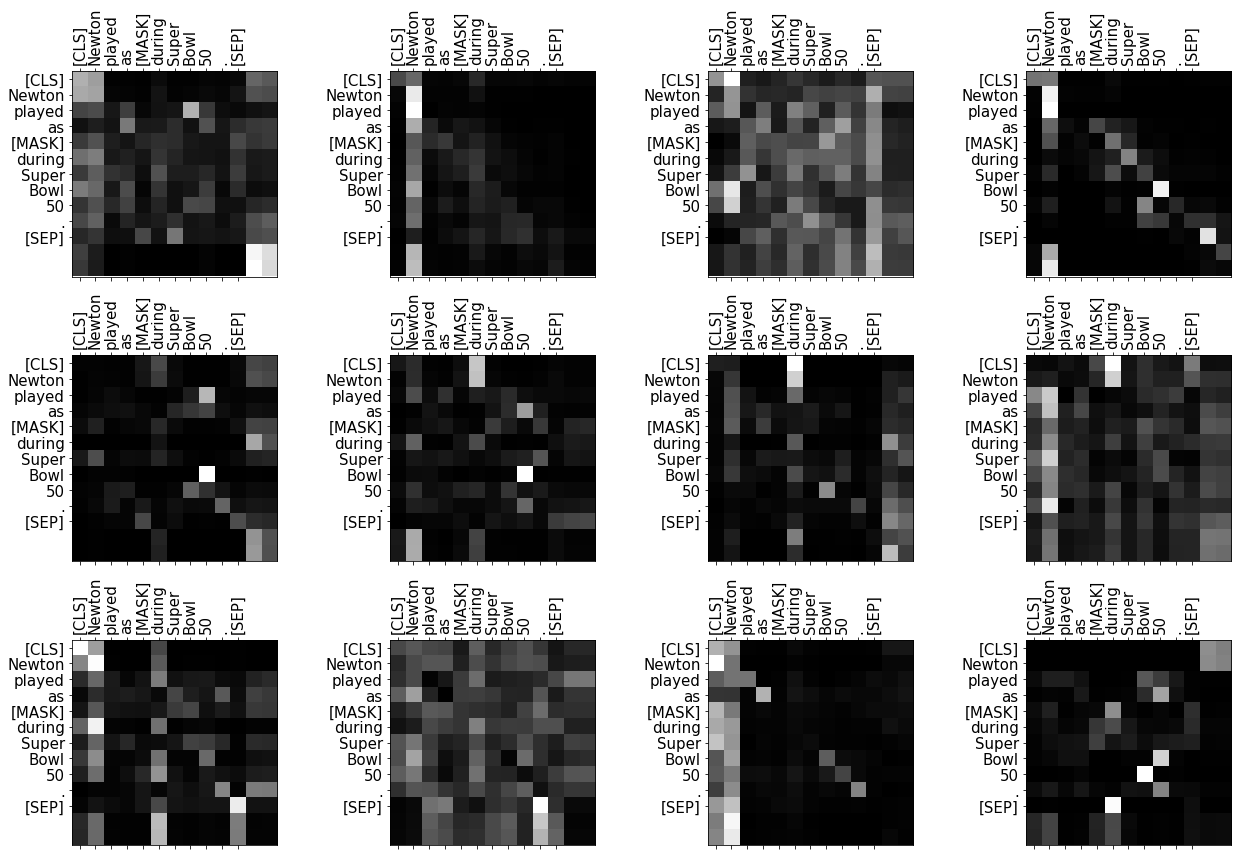

In [ ]:
correct = [r for r in results if r['correct@1']]
wrong = [r for r in results if not r['correct@1']]

def show(idx=0, attn_layer=0, is_correct=True):
    result = correct[idx] if is_correct else wrong[idx]

    top_str = '\n\t'.join([('\t%s\t(%.4f)' % (t, p)) for t, p in zip(result['top_tokens'], result['top_probs'])])
    print("""%s
    \tlabel:\t%s

    \ttop:%s
    """ % (result['sentence'], result['label'], top_str))

    print("Attention weights (12 heads) from layer %d:" % attn_layer)
    # --- visualize attention
    fig, axs = plt.subplots(3, 4, figsize=(18, 12))

    toks = ['[CLS]'] + tokenizer.tokenize(result['sentence']) + ['[SEP]']
    for i, ax in enumerate(axs.reshape(-1)):
        ax.matshow(result['attn'][attn_layer][0][i].data.cpu().numpy(), cmap='gray')

        ax.set_xticks(range(len(toks)))
        ax.set_xticklabels(toks, rotation=90, fontsize=15)
        ax.set_yticks(range(len(toks)))
        ax.set_yticklabels(toks, fontsize=15)
    plt.tight_layout()
    
interactive(show, idx=(0, min(len(correct), len(wrong))-1), attn_layer=range(12), is_correct=True)

---
## References
- DS-GA 1011 NLP with Representation Learning Fall 2020